# Assigment 04: Due 9/30

You can use these imports

In [1]:
import numpy as np
from math import e
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit #simpliest scipy fitting method
import scipy.special as sf
%matplotlib notebook

def chisq(xs: np.array, ys: np.array, function, sigmas: np.array, popt: np.array):
    '''*NUMPY REQUIRED* Calculates Chi Squared, Degrees of Freedom, and Reduced Chi Squared'''
    chisq = np.sum( (ys - function(xs, *popt))**2 /  sigmas**2 )
    dof = len(xs) - len(popt) - 1
    rchisq = chisq / dof
    return chisq, dof, rchisq

# Problem 1a

Using Monte Carlo techniques discusses in *02_Integration_MC* notebook, solve the following integral and compare it to the exact solution:

$\int_0^2 \frac{2}{(2^2 + x^2)^{3/2}}dx$

In your Monte Carlo integration, use 10,000 random points.

In [2]:
f = lambda x: 2 / (2**2 + x**2)**(3/2)

In [3]:
x = np.linspace(0,2,10000)
y = f(x)

fmax = max(y)
x_rand = 2*np.random.random(10000)
y_rand = fmax*np.random.random(10000)

ind_below = np.where(y_rand < f(x_rand))
ind_above = np.where(y_rand >= f(x_rand))

ratio = float(len(ind_below[0])/10000)
area = 2*fmax
integral = ratio*area

# 1b

Make a scatter plot of points below and above the integrand function. This is the some type of graph shown in the *02_Integration_MC* notebook with the blue and green points.

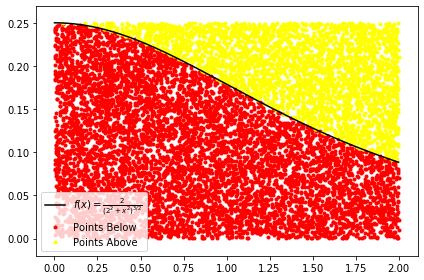

In [4]:
figure = plt.figure('MC Integration')
fig = plt.figure('MC Integration')
plt.scatter(x_rand[ind_below], y_rand[ind_below], color = "red", marker = '.',label='Points Below')
plt.scatter(x_rand[ind_above], y_rand[ind_above], color = "yellow", marker = '.', label = 'Points Above')
plt.plot(x, y, color = "black", label= r'$f(x)=\frac{2}{(2^2 + x^2)^{3/2}}$')
plt.legend()
plt.tight_layout();

# Problem 2a
Read in the data set *./data/decay_data.txt*, this lists the time in days, number of particles, and the uncertianty on the particles. This is the same radio active decay data set used in our fitting example *Fitting_Lecture_Notes* from Module 2b.

Plot the data with its error bars.


In [5]:
days, N, N_error = np.loadtxt('data/decay_data.txt', unpack = True)

<ErrorbarContainer object of 3 artists>

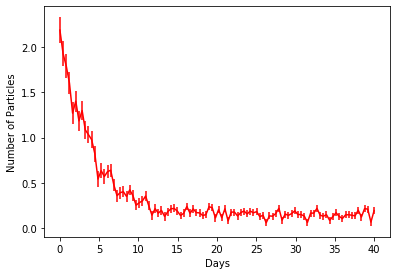

In [6]:
fig = plt.figure()
axes = fig.add_axes([0.15,0.1,0.8,0.8])
axes.set_xlabel('Days')
axes.set_ylabel('Number of Particles')
axes.errorbar(days, N, yerr = N_error, fmt='r-')

# Problem 2b

Fit the data with 3 fit parameters using MCMC MH algorithm. You should take 10,000 steps and impliment the random test on $\chi ^2$, like we did our *03_MC_Fit* example notebook using the *get_chi_squared* function. For this we will use a function template of: $y = p_0 \cdot e^{-t/p_1} + p_2$,

where $p_0, p_1$, and $p_2$ are the fit parameters. When fitting you should choose starting values of $p_0 = p_1 = p_2 = 1.0$ to avoid nan errors.

In [7]:
def get_chi_squared(x: np.array, y: np.array, sigma: np.array, params: np.array):
    '''Returns the chi squared of the fit'''
    if len(params) != 3:
        raise ValueError('Parameter must have three elements.')
    RR = 0.0
    #print(sigma)
    for i in range(len(x)):
        y_prime = params[0] * e**(-x[i] / params[1]) + params[2]
        RR += ( (y[i] - y_prime) / sigma[i])**2
    return RR

f2 = lambda t,p0,p1,p2 : p0 * e**(-t / p1) + p2

n = 10000
init_par = np.array([1.0,1.0,1.0])
par_list, RRs = [init_par], [get_chi_squared(days,N,N_error,init_par)]

#The Monte Carlo Algorithm
for i in range(n):
    test_par = [np.random.normal(par_list[-1][0],0.5),np.random.normal(par_list[-1][1],0.5),np.random.normal(par_list[-1][2],0.5)]
    RR_test = get_chi_squared(days,N,N_error,test_par)
    if (np.random.random() <= (RRs[-1])/RR_test ):
        #add test parameter to array
        par_list.append(test_par)
        RRs.append(RR_test)
    else:
        #add previous test paramter to array
        par_list.append(par_list[-1])
        RRs.append(RRs[-1])   

RR_min = np.amin(RRs) #find min R2
chisq = RR_min
best_i = RRs.index(RR_min) #Get the index
best_pars = par_list[best_i]  #get the parameters  
print("best p0 = {0}, best p1 = {1}, best p2 = {2}, chi**2 = {3}, loc = {4}".format(best_pars[0], best_pars[1], best_pars[2], RR_min, best_i))


/Users/jasonbreslin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
/Users/jasonbreslin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  


best p0 = 1.95446449094917, best p1 = 3.9468255142539146, best p2 = 0.13836228869146883, chi**2 = 105.09539667469312, loc = 1478


# Problem 2c

What is the reduced $\chi^2$ of your fit and the p-value?
Is this a good fit?

In [8]:
dof = len(days) - len(init_par) - 1
pvalue = sf.gammaincc(dof/2.0, chisq/2.0)
print('Fit Results:\n reduced chi2 = ', chisq/dof, '\n p-value = ',pvalue)

Fit Results:
 reduced chi2 =  1.0947437153613866 
 p-value =  0.24682436180755907


This is a good fit for the data becauase the p-value is a very low value meaning there is a low chance that there are better test parameters that could be randomly found.

# Problem 2d

Plot on the same graph your data and the line showin the fitted function.

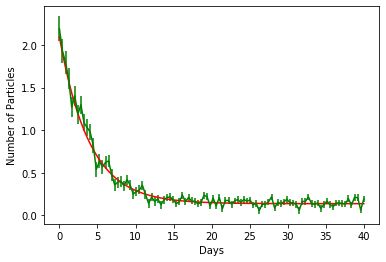

In [11]:
fig = plt.figure('Fitted Data Set')
plt.errorbar(days, N, yerr = N_error, fmt='g-')
plt.xlabel('Days')
plt.ylabel('Number of Particles')
plt.plot(days,f2(days,*best_pars),'r');

# Problem 2e

Plot the histogram distributions of the three fit parameters.

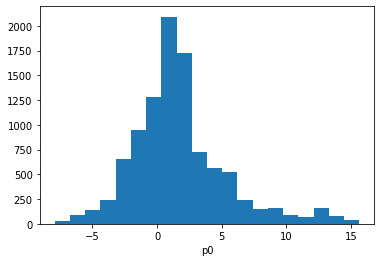

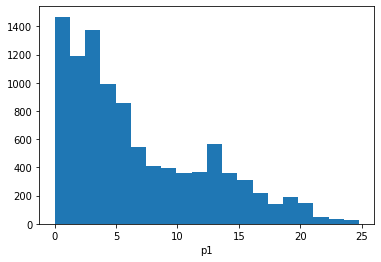

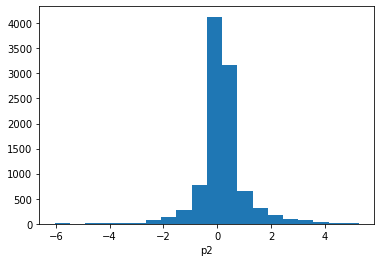

In [10]:
#Convert the parameter list to an array
ps = np.array(par_list)

#Plot hist for p0
figp0 = plt.figure(0)
plt.figure(0)
plt.hist(ps[:,0], bins=20)
plt.xlabel("p0");

#Plot hist for p1
figp0 = plt.figure(1)
plt.figure(1)
plt.hist(ps[:,1], bins=20)
plt.xlabel("p1");

#Plot hist for p2
figp0 = plt.figure(2)
plt.figure(2)
plt.hist(ps[:,2], bins=20)
plt.xlabel("p2");